# Lab 5 - Transportation Problem

<b>Information on group members:</b><br>
1) 156035, Kuba Czech <br>
2) 156045, Wojciech Nagórka

In [83]:
from pulp import *
import numpy as np
import matplotlib.pyplot as plt
import random
import time

In [86]:
class TransportationProblem():
    def __init__(self,m,n):
        self.demands=list()
        self.costs=list()
        self.supplies=list()
        self.m=m
        self.n=n
        self.base=set()
        self.entering_var=None
        self.number_of_it = 0
    
    def createRandomInstance(self):
        demand=random.randint(100,1000)
        breakpoints = sorted(random.sample(range(1, demand), self.m - 1))
        self.demands = [a - b for a, b in zip(breakpoints + [demand], [0] + breakpoints)]
        breakpoints = sorted(random.sample(range(1, demand), self.n - 1))
        self.supplies = [a - b for a, b in zip(breakpoints + [demand], [0] + breakpoints)]
        for i in range(self.n):
            temp=[]
            for i in range(self.m):
                if random.randint(1,20) <= 12:
                    temp.append(random.randint(1,10))
                else:
                    if random.random()<=0.8:
                        temp.append(0)
                    else:
                        temp.append(1e6)
            self.costs.append(temp)
    
    def createBase(self):
        n_, m_ = 0, 0
        self.arr = np.zeros((self.n, self.m))  
        self.arr[0, 0] = min(self.demands[0], self.supplies[0])
        self.base.add((0, 0))
        while len(self.base) < self.m + self.n - 1:
            col_sum = np.sum(self.arr[:n_ + 1, m_])  
            if col_sum < self.demands[m_] and n_ < self.n - 1:
                n_ += 1
                self.arr[n_, m_] = min(
                    self.demands[m_] - col_sum, self.supplies[n_] - np.sum(self.arr[n_, :m_ + 1])
                )
                self.base.add((n_, m_))
            else:
                m_ += 1
                row_sum = np.sum(self.arr[n_, :m_])
                self.arr[n_, m_] = min(
                    self.supplies[n_] - row_sum, self.demands[m_] - np.sum(self.arr[:n_ + 1, m_])
                )
                self.base.add((n_, m_))

    def find_uv(self):
        self.u=[None for i in range(self.m)]
        self.v=[None for i in range(self.n)]
        base=sorted(list(self.base))
        A=[]
        b=[]
        for cord in base:
            n_,m_=cord
            A.append([1 if i==n_ else 0 for i in range(self.n)]+[1 if i==m_ else 0 for i in range(self.m)])
            b.append(self.costs[n_][m_])
        A=np.array(A)
        b=np.array(b)
        x, residuals, rank, s = np.linalg.lstsq(A, b, rcond=None)
        self.u = x[:self.n]
        self.v = x[self.n:]
        
    def calc_row_zero(self):
        for n_ in range(self.n):
            for m_ in range(self.m):
                if (n_,m_) not in self.base:
                    self.arr[n_,m_]=self.costs[n_][m_]-self.u[n_]-self.v[m_]
                    
                    
    def find_entering_variable(self):
        flat_index=np.argmin(self.arr)
        index=np.unravel_index(flat_index,self.arr.shape)
        self.entering_var=index
    
    def find_loop(self, indexes, length):
        if length > 2 and (indexes[0][0] == indexes[length][0] or indexes[0][1] == indexes[length][1]):
            return indexes

        n_, m_ = indexes[length]
        if length % 2 == 0: 
            for n in range(self.n):
                if (n, m_) in self.base and (n, m_) not in indexes:
                    result = self.find_loop(indexes + [(n, m_)], length + 1)
                    if result is not None:
                        return result
        else: 
            for m in range(self.m):
                if (n_, m) in self.base and (n_, m) not in indexes:
                    result = self.find_loop(indexes + [(n_, m)], length + 1)
                    if result is not None:
                        return result
  
    
    def update_arr(self,indexes):
        base_leaving=None
        minimum=float('inf')
        for i in range(1,len(indexes),2):
            if self.arr[indexes[i]]<minimum:
                minimum=self.arr[indexes[i]]
                base_leaving=indexes[i]
        self.arr[indexes[0]]=minimum
        for i in range(1,len(indexes)):
            if i%2==0:
                self.arr[indexes[i]]+=minimum
            else:
                self.arr[indexes[i]]-=minimum
        self.base.remove(base_leaving)
        self.base.add(self.entering_var)
        
    def getBase(self):
        return self.base

    def solve(self):
        self.createBase()
        while True:
            self.number_of_it += 1
            self.find_uv()
            self.calc_row_zero()
            if np.min(self.arr)>=-10**(-6):
                break
            self.find_entering_variable()
            indexes=self.find_loop([self.entering_var],0)
            self.update_arr(indexes)
        
        obj_f=0
        for n_ in range(self.n):
            for m_ in range(self.m):
                if (n_,m_) in self.base:
                    obj_f+=self.costs[n_][m_] * self.arr[n_,m_]
        return obj_f

In [85]:
x=TransportationProblem(10, 10)
x.createRandomInstance()
x.solve()

1114.0

In [144]:
def TSAandPuLPComparison(size_m, size_n, n):
    pulp_values = []
    st_values = []
    counter_of_iterations = []
    
    st_time = []
    pulp_time = []

    for _ in range(n):
        #TSA part
        x=TransportationProblem(size_m, size_n)
        x.createRandomInstance()
        start = time.time()
        Z = x.solve()
        finish = time.time()

        st_values.append(Z)
        st_time.append(finish - start)
        nr_of_iterations = x.number_of_it
        counter_of_iterations.append(nr_of_iterations)

        supplies = x.supplies
        demands = x.demands
        costs = x.costs

        # PuLP part
        start = time.time()
        model = LpProblem(name="transportation-simplex", sense=LpMinimize)
        var_names = [f"x_({i},{j})" for i in range(len(supplies)) for j in range(len(demands))]
        x = LpVariable.dicts("x", var_names, cat = 'Integer', lowBound=0)

        var_names_rows = [[f"x_({j},{i})" for i in range(len(demands))] for j in range(len(supplies))]
        sense_rows = [0 for _ in range(len(supplies))]
        const_names_rows = [f"row{i}" for i in range(len(supplies))]

        for j, s, r, cn in zip(range(len(supplies)), sense_rows, supplies, const_names_rows):
            expr = lpSum([x[var_names_rows[j][i]] * 1 for i in range(len(demands))])
            model += LpConstraint(e=expr, sense = s, name = cn, rhs = r)

        var_names_cols = [[f"x_({i},{j})" for i in range(len(supplies))] for j in range(len(demands))]
        sense_cols = [0 for _ in range(len(demands))]
        const_names_cols = [f"column{i}" for i in range(len(demands))]

        for j, s, r, cn in zip(range(len(demands)), sense_cols, demands, const_names_cols):
            expr = lpSum([x[var_names_cols[j][i]] * 1 for i in range(len(demands))])
            model += LpConstraint(e=expr, sense = s, name = cn, rhs = r)
            
        obj_coefs = [costs[i][j] for i in range(len(supplies)) for j in range(len(demands))]
        model += lpSum([x[var_names[i]] * obj_coefs[i] for i in range(len(obj_coefs))])

        status = model.solve()
        finish = time.time()
        pulp_time.append(finish - start)
        pulp_values.append(model.objective.value())

    assert (pulp_values == st_values)
    return st_values, pulp_values, counter_of_iterations, st_time, pulp_time
    

In [146]:
sizes = [5, 10, 15, 20, 25, 30, 40, 45, 50, 60, 75, 90, 100]
values = {"avgs": [], "st_times": [], "pulp_times": []}

for size in sizes: 
    st_values, pulp_values, nr_of_iterations, st_time, pulp_time = TSAandPuLPComparison(size, size, 10)
    values["avgs"].append(np.mean(nr_of_iterations))
    values["st_times"].append(np.mean(st_time))
    values["pulp_times"].append(np.mean(pulp_time))

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/Kuba/Library/Python/3.9/lib/python/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/8m/nx_b_wh17dg77b9kb95gxng80000gp/T/6ba2d25b642549bf86298268daf3d572-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/8m/nx_b_wh17dg77b9kb95gxng80000gp/T/6ba2d25b642549bf86298268daf3d572-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 15 COLUMNS
At line 133 RHS
At line 144 BOUNDS
At line 170 ENDATA
Problem MODEL has 10 rows, 25 columns and 50 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 1411 - 0.00 seconds
Cgl0004I processed model has 10 rows, 25 columns (25 integer (0 of which binary)) and 50 elements
Cutoff increment increased from 1e-05 to 0.9999
Cbc0012I Integer solution of 1411 found by DiveCoefficient after 0 iterations and 0 nodes (0.00 seconds)
Cbc0001I

In [147]:
values["st_times"]

[0.0005893945693969726,
 0.0023755788803100585,
 0.008096528053283692,
 0.01949610710144043,
 0.04383001327514648,
 0.12024688720703125,
 0.28235816955566406,
 0.3579315423965454,
 0.5423740863800048,
 0.9672091245651245,
 2.0086660385131836,
 3.4499967098236084,
 4.574630570411682]

In [148]:
values["pulp_times"]

[0.02193894386291504,
 0.022527003288269044,
 0.02592942714691162,
 0.030666232109069824,
 0.03644497394561767,
 0.06007020473480225,
 0.06276195049285889,
 0.07444710731506347,
 0.1059568166732788,
 0.1472867250442505,
 0.2124249219894409,
 0.3080862522125244,
 0.3910560369491577]

In [149]:
for i in range(len(sizes)):
    print(f"For 10 iterations and matrix of size {sizes[i]}, transportation simplex needed on average {values['avgs'][i]} iterations")

For 10 iterations and matrix of size 5, transportation simplex needed on average 5.6 iterations
For 10 iterations and matrix of size 10, transportation simplex needed on average 17.6 iterations
For 10 iterations and matrix of size 15, transportation simplex needed on average 35.4 iterations
For 10 iterations and matrix of size 20, transportation simplex needed on average 51.8 iterations
For 10 iterations and matrix of size 25, transportation simplex needed on average 74.3 iterations
For 10 iterations and matrix of size 30, transportation simplex needed on average 88.0 iterations
For 10 iterations and matrix of size 40, transportation simplex needed on average 121.7 iterations
For 10 iterations and matrix of size 45, transportation simplex needed on average 138.5 iterations
For 10 iterations and matrix of size 50, transportation simplex needed on average 149.1 iterations
For 10 iterations and matrix of size 60, transportation simplex needed on average 195.1 iterations
For 10 iterations 

# **Report** #

**Sizes tested for our experiments: [5, 10, 15, 20, 25, 30, 40, 45, 50, 60, 75, 90, 100]**

## **Solution of problem from classes** ##

In [145]:
x=TransportationProblem(4,4)
x.supplies=[30,20,80,80]
x.demands=[40,40,20,110]
x.costs=[[7,5,5,0],[3,10,10,float('inf')],[3,10,10,0],[float('inf'),float('inf'),0,0]]
x.solve()

370.0

Objective function is equal to the one calculated durign the classes - our solution works for the small problems. Below we will see if it also works for matrices of higher size.

## **Size of matrix vs number of iterations** ##

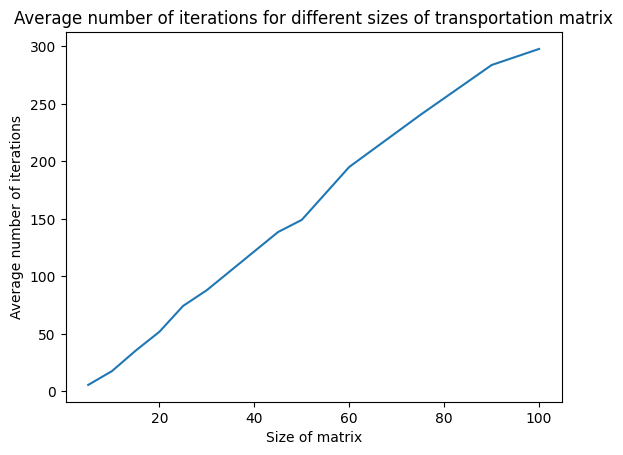

In [150]:
plt.plot(sizes, values["avgs"])
plt.xlabel('Size of matrix')
plt.ylabel('Average number of iterations')
plt.title('Average number of iterations for different sizes of transportation matrix')
plt.show()

As we can see, number of iterations depends linearly on the size of our problem

## **Size of matrix vs time of computation (our algorithm)** ##

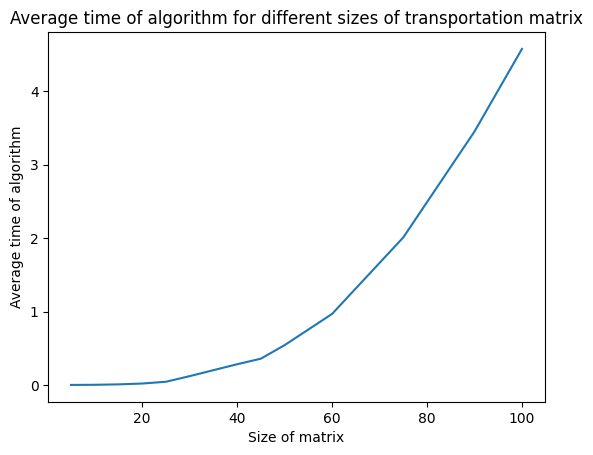

In [151]:
plt.plot(sizes, values["st_times"])
plt.xlabel('Size of matrix')
plt.ylabel('Average time of algorithm')
plt.title('Average time of algorithm for different sizes of transportation matrix')
plt.show()

As we can see, time of computations depends quadratically on the size of the problem. And that actually make sense because for bigger problems we will have more iterations and in each such iteration we will do more mathematical operations and this will take more time

## **Size of matrix vs time of computation (pulp library)** ##

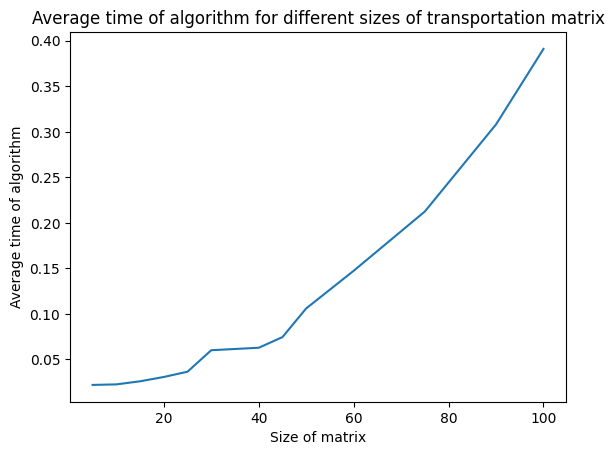

In [152]:
plt.plot(sizes, values["pulp_times"])
plt.xlabel('Size of matrix')
plt.ylabel('Average time of algorithm')
plt.title('Average time of algorithm for different sizes of transportation matrix')
plt.show()

## **Comparison of our algorithm and pulp** ##

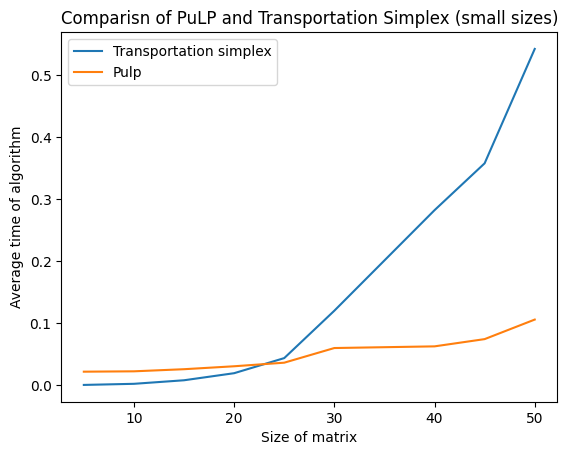

In [172]:
end = 9
plt.plot(sizes[:end], values["st_times"][:end])
plt.plot(sizes[:end], values["pulp_times"][:end])
plt.xlabel('Size of matrix')
plt.ylabel('Average time of algorithm')
plt.legend(["Transportation simplex", "Pulp"])
plt.title('Comparisn of PuLP and Transportation Simplex (small sizes)')
plt.show()

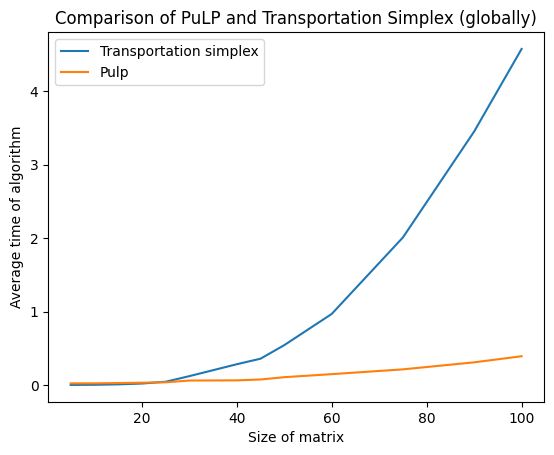

In [171]:
plt.plot(sizes, values["st_times"])
plt.plot(sizes, values["pulp_times"])
plt.xlabel('Size of matrix')
plt.ylabel('Average time of algorithm')
plt.legend(["Transportation simplex", "Pulp"])
plt.title('Comparison of PuLP and Transportation Simplex (globally)')
plt.show()

Both algorithms take more time when size is increased (qudratic function) but both produce equally good solutions (objective function is the same). However, for sizes bigger than 25, PuLP gains advantage and produces solutions in shorter time (the bigger the size the higher the difference). For small sizes (<= 25) transportation simplex algorithm implemented by us works faster.